In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 0. 시드 고정 (재현성)

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. 데이터 로드

df = pd.read_csv('../../preprocessing/log공선성제거_Final_data.csv')
df["ret_prev"] = (df["y_target_log"] - df["y_target_log"].shift(1))

# Date 컬럼
date_col = "Date"

# y_target 컬럼 (타깃)
target_col = "ret_prev"

df[date_col] = pd.to_datetime(df[date_col])

# 숫자형만 사용 + 결측 제거
df_num = df.select_dtypes(include=[np.number]).dropna()

# 숫자행에 맞는 날짜만 따로 정렬 (인덱스 맞추기용)
dates_num = df.loc[df_num.index, date_col].reset_index(drop=True)

# X: y_target 제외
feature_cols = [c for c in df_num.columns if c != target_col or 'y_target_log']
X_raw = df_num[feature_cols].values
y_raw = df_num[[target_col]].values

print("X_raw shape:", X_raw.shape)
print("y_raw shape:", y_raw.shape)

X_raw shape: (753, 7)
y_raw shape: (753, 1)


In [2]:
import joblib

In [3]:
# 2. 스케일링 (X / y 따로)

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_raw)

joblib.dump(scaler_X, "../../modeling/Model/GRU_scaler_X.joblib")
joblib.dump(scaler_y, "../../modeling/Model/GRU_scaler_y.joblib")


# ===============================
# 3. 시계열 데이터셋 생성 함수
# ===============================
def make_dataset(X_arr, y_arr, seq_len):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i:i+seq_len])      # (seq_len, num_features)
        ys.append(y_arr[i+seq_len])        # (1,)
    return np.array(Xs), np.array(ys)


# 4. 모델 정의 (GRU only)

def build_model(seq_len, num_features):
    inputs = Input(shape=(seq_len, num_features))

    # GRU 스택
    x = GRU(64, return_sequences=True)(inputs)

    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='mse',
        metrics=['mae']
    )
    return model



In [4]:

# 5. seq_len 후보 [5,15,30,60,90] 중 최적 선택 (val_loss 기준)

candidate_seq_lens = list(range(1, 51))


best_seq_len  = None
best_val_loss = np.inf

for seq_len in candidate_seq_lens:
    # 1) 시퀀스 데이터 생성
    X_tmp, y_tmp = make_dataset(X_scaled, y_scaled, seq_len)
    n_samples = len(X_tmp)

    if n_samples < 10:
        print(f"seq_len={seq_len} → 샘플 수 부족 (n={n_samples}), 스킵")
        continue

    # 2) Train / Val / Test 분할 
    test_size = int(n_samples * 0.20)
    remaining = n_samples - test_size
    val_size = int(remaining * 0.20)
    train_size = remaining - val_size
    val_end    = train_size + val_size
    train_end  = train_size

    X_train_tmp = X_tmp[:train_end]
    y_train_tmp = y_tmp[:train_end]

    X_val_tmp   = X_tmp[train_end:val_end]
    y_val_tmp   = y_tmp[train_end:val_end]

    # 3) 임시 모델 생성
    model_tmp = build_model(seq_len, X_tmp.shape[2])

    early_tmp = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # 4) 학습
    history_tmp = model_tmp.fit(
        X_train_tmp, y_train_tmp,
        validation_data=(X_val_tmp, y_val_tmp),
        epochs=200,
        batch_size=64,
        callbacks=[early_tmp],
        verbose=0,
        shuffle=False
    )

    # 5) 최소 val_loss
    val_loss = min(history_tmp.history["val_loss"])
    print(f"seq_len={seq_len} → best val_loss={val_loss:.6f}")

    # 6) 최적 seq_len 갱신
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_seq_len  = seq_len

print(f"\n최적 seq_len = {best_seq_len}, best val_loss = {best_val_loss:.6f}")


seq_len=1 → best val_loss=0.006089
seq_len=2 → best val_loss=0.005332
seq_len=3 → best val_loss=0.005341
seq_len=4 → best val_loss=0.005102
seq_len=5 → best val_loss=0.005422
seq_len=6 → best val_loss=0.005521
seq_len=7 → best val_loss=0.005589
seq_len=8 → best val_loss=0.005502
seq_len=9 → best val_loss=0.005576
seq_len=10 → best val_loss=0.005649
seq_len=11 → best val_loss=0.005797
seq_len=12 → best val_loss=0.005806
seq_len=13 → best val_loss=0.005261
seq_len=14 → best val_loss=0.008566
seq_len=15 → best val_loss=0.008583
seq_len=16 → best val_loss=0.008773
seq_len=17 → best val_loss=0.008771
seq_len=18 → best val_loss=0.008690
seq_len=19 → best val_loss=0.009429
seq_len=20 → best val_loss=0.009398
seq_len=21 → best val_loss=0.009421
seq_len=22 → best val_loss=0.009373
seq_len=23 → best val_loss=0.009444
seq_len=24 → best val_loss=0.009569
seq_len=25 → best val_loss=0.009605
seq_len=26 → best val_loss=0.009617
seq_len=27 → best val_loss=0.009519
seq_len=28 → best val_loss=0.009535
s

In [5]:
# 6 최적 seq_len으로 다시 시퀀스 생성
X_best, y_best = make_dataset(X_scaled, y_scaled, best_seq_len)
n_samples = len(X_best)

train_size = int(n_samples * 0.6)
val_size   = int(n_samples * 0.2)
test_size  = n_samples - train_size - val_size  # 나머지

print(f"전체 샘플 수 (n_samples): {n_samples}")
print(f"train 샘플 수          : {train_size}")
print(f"val 샘플 수            : {val_size}")
print(f"test(남는 구간) 샘플 수 : {test_size}")

print("X_best shape:", X_best.shape)
print("y_best shape:", y_best.shape)


전체 샘플 수 (n_samples): 749
train 샘플 수          : 449
val 샘플 수            : 149
test(남는 구간) 샘플 수 : 151
X_best shape: (749, 4, 7)
y_best shape: (749, 1)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 7. 최종 모델 정의 및 학습 + 최적 모델 저장

SEQ_LEN = best_seq_len  

# X_best, y_best를 train/val/test로 나누는 코드가 있어야 합니다
X_train = X_best[:train_size]
y_train = y_best[:train_size]

X_val   = X_best[train_size:train_size+val_size]
y_val   = y_best[train_size:train_size+val_size]

X_test  = X_best[train_size+val_size:]
y_test  = y_best[train_size+val_size:]

# 최종 모델 생성
model = build_model(SEQ_LEN, X_train.shape[2])
model.summary()

# EarlyStopping (가장 좋은 weight로 복원)
early = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# ModelCheckpoint: val_loss가 갱신될 때만 모델 저장
checkpoint_path = "../../modeling/Model/GRU_best.keras"  # 저장 경로 원하는 대로 수정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,   # 가장 좋은 모델만 저장
    save_weights_only=False,  # 전체 모델(구조+가중치) 저장
    mode='min',
    verbose=1
)

# 학습: 콜백에 EarlyStopping + Checkpoint 둘 다 넣기
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=64,
    # callbacks=[early, checkpoint],
    callbacks=[checkpoint], 
    verbose=1,
    shuffle=False
)


Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 4, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_52 (GRU)                    │ (None, 4, 64)          │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 4, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.1076 - mae: 0.3203
Epoch 1: val_loss improved from None to 0.02809, saving model to ../../modeling/Model/GRU_best.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0510 - mae: 0.1980 - val_loss: 0.0281 - val_mae: 0.1431
Epoch 2/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0178 - mae: 0.1078
Epoch 2: val_loss did not improve from 0.02809
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0204 - mae: 0.1205 - val_loss: 0.0286 - val_mae: 0.1450
Epoch 3/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - mae: 0.0979 
Epoch 3: val_loss improved from 0.02809 to 0.00965, saving model to ../../modeling/Model/GRU_best.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0127 - mae: 0.0911 - val_loss: 0.0096 - val_mae: 0.0768
Epoch 4/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0145 - mae: 0.0969
Epoch 4: val_loss improved from 0.00965 to 0.00788, saving model to ../../modeling/Model/GRU_best.keras
8/8 ━━━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model

# 체크포인트에서 최적 모델 불러오기
best_model = load_model(checkpoint_path)

# 8. 예측 + y 스케일 해제 (하루씩 예측)

pred_list = []

for i in range(len(X_test)):
    # i번째 테스트 구간 하나만 꺼냄: shape = (1, SEQ_LEN, num_features)
    x_input = X_test[i:i+1]

    # 하루치 예측 (출력 shape: (1, 1) 가정)
    pred_i = model.predict(x_input, verbose=0)[0, 0]
    pred_list.append(pred_i)

# 리스트 -> 배열로 변환
pred_scaled   = np.array(pred_list).reshape(-1, 1)
y_test_scaled = y_test

# MinMax 역변환 (원래 y_target 스케일)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)
pred_inv   = scaler_y.inverse_transform(pred_scaled)


In [10]:
# 9. Date도 test 구간에 맞게 자르기
start_idx = SEQ_LEN + train_size + val_size
end_idx   = start_idx + len(y_test_inv)

# df가 아니라 df_num에 맞춘 dates_num 사용 (인덱스 정합)
date_test = dates_num.iloc[start_idx:end_idx].reset_index(drop=True)


        Date    y_true    y_pred
0 2025-04-04 -0.060327 -0.003805
1 2025-04-07 -0.001783 -0.003158
2 2025-04-08 -0.015787 -0.003956
3 2025-04-09  0.099863 -0.006235
4 2025-04-10 -0.044808 -0.001424
Test RMSE (original scale): 0.0141
Test MAE  (original scale): 0.0086
Test R^2  (original scale): -0.1718


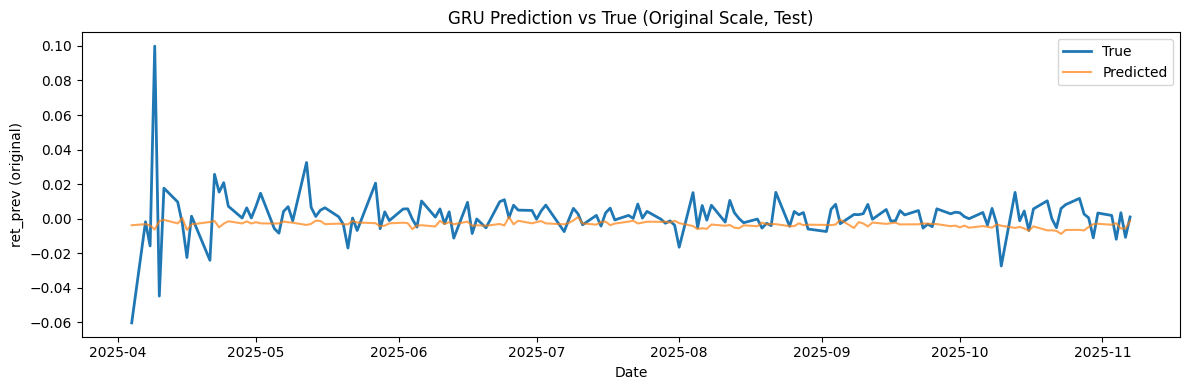

In [11]:
# 10. 결과 DataFrame (원래 스케일)

result = pd.DataFrame({
    "Date": date_test,
    "y_true": y_test_inv.flatten(),
    "y_pred": pred_inv.flatten()
})

print(result.head())

# 11. 지표 (RMSE / MAE / R²) - 원래 스케일 기준

rmse = np.sqrt(mean_squared_error(result["y_true"], result["y_pred"]))
mae  = mean_absolute_error(result["y_true"], result["y_pred"])
r2   = r2_score(result["y_true"], result["y_pred"])

print(f"Test RMSE (original scale): {rmse:.4f}")
print(f"Test MAE  (original scale): {mae:.4f}")
print(f"Test R^2  (original scale): {r2:.4f}")


# 12. 그래프: True vs Pred (달러 스케일)
plt.figure(figsize=(12, 4))
plt.plot(result["Date"], result["y_true"], label="True", linewidth=2)
plt.plot(result["Date"], result["y_pred"], label="Predicted", alpha=0.7)
plt.title("GRU Prediction vs True (Original Scale, Test)")
plt.xlabel("Date")
plt.ylabel(target_col + " (original)")
plt.legend()
plt.tight_layout()
plt.show()

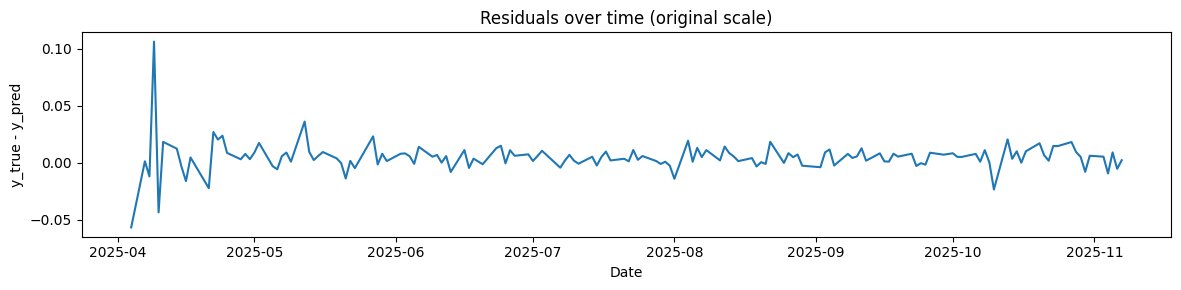

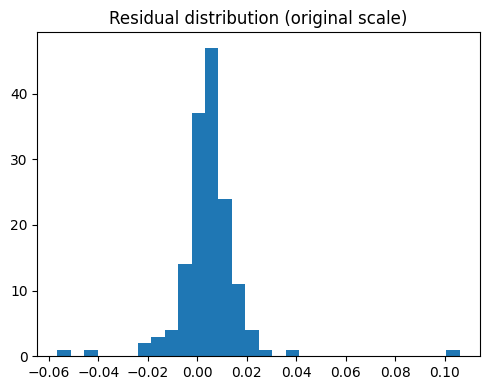

In [12]:
# 12. 잔차(residual) 분석 (달러 스케일)

residuals = result["y_true"] - result["y_pred"]

plt.figure(figsize=(12, 3))
plt.plot(result["Date"], residuals)
plt.title("Residuals over time (original scale)")
plt.xlabel("Date")
plt.ylabel("y_true - y_pred")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(residuals, bins=30)
plt.title("Residual distribution (original scale)")
plt.tight_layout()
plt.show()

In [14]:
print(f"\n✅ 최적 seq_len = {best_seq_len}, best val_loss = {best_val_loss:.6f}")


✅ 최적 seq_len = 4, best val_loss = 0.005102


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


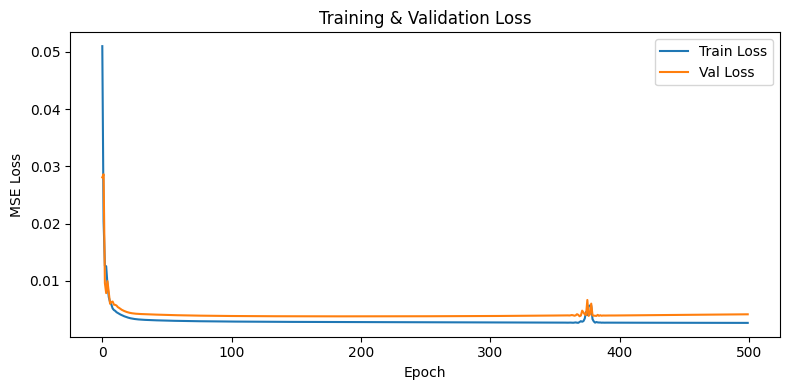

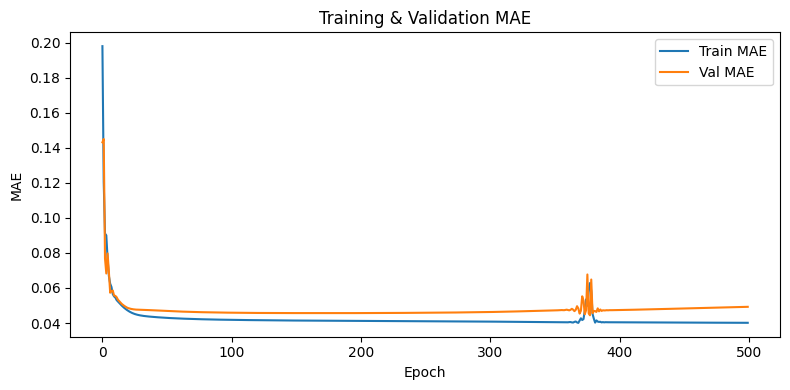

In [13]:

# 13. 학습 곡선 시각화 (Loss / MAE)

# history.history 안에 들어있는 키 확인 (디버깅용)
print(history.history.keys())

# 1) Loss (train vs val)
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 2) MAE (train vs val)
if "mae" in history.history and "val_mae" in history.history:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Val MAE")
    plt.title("Training & Validation MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()


        Date  Price_true_df  Price_true_from_ret  Price_pred
0 2025-04-04       6.285439             6.275649    6.332170
1 2025-04-07       6.225113             6.283657    6.282281
2 2025-04-08       6.223330             6.209326    6.221156
3 2025-04-09       6.207543             6.323193    6.217095
4 2025-04-10       6.307406             6.162735    6.206119
Price RMSE : 0.0145
Price MAE  : 0.0089
Price R^2  : 0.9635


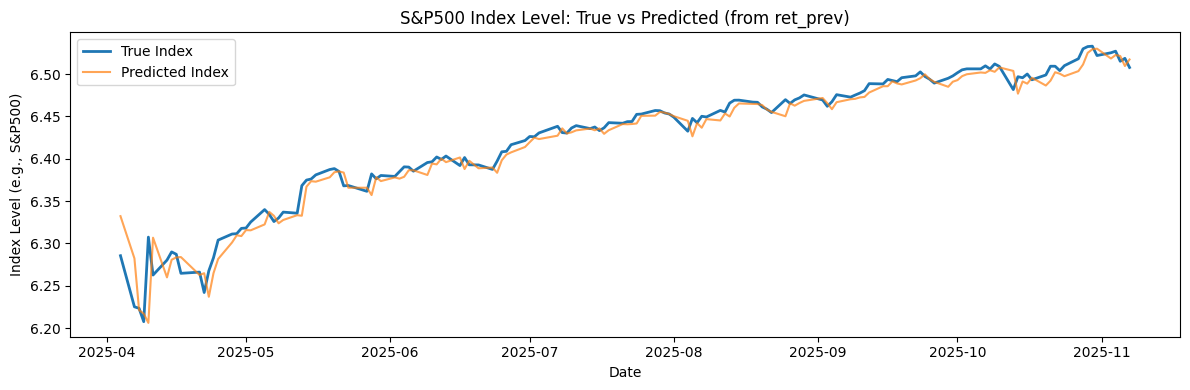

In [15]:

# 14. 예측 수익률 → 예측 S&P500 지수로 변환

price_col = "y_target_log" 

# test 구간 길이
n_test = len(y_test_inv)

# y_test / pred가 대응하는 원본 인덱스 범위
start_idx = SEQ_LEN + train_size + val_size
idx_curr_start = start_idx
idx_curr_end   = start_idx + n_test

# 1) 실제 S&P500 지수 (오늘 기준 P_t)
price_true = df[price_col].iloc[idx_curr_start:idx_curr_end].to_numpy()

# 2) 수익률 기준이 되는 "어제 지수" P_{t-1}
price_prev = df[price_col].iloc[idx_curr_start-1:idx_curr_start-1 + n_test].to_numpy()

# 3) 예측/실제 수익률 (디스케일링된 값)
ret_true = y_test_inv.flatten()
ret_pred = pred_inv.flatten()

# 4) 수익률 → 지수로 복원

price_pred_from_ret = price_prev + ret_pred
price_true_from_ret = price_prev + ret_true

# 5) 결과 DataFrame (날짜 + 실제 지수 + 예측 지수)
result_price = pd.DataFrame({
    "Date": date_test.reset_index(drop=True),
    "Price_true_df": price_true,
    "Price_true_from_ret": price_true_from_ret,
    "Price_pred": price_pred_from_ret
})

print(result_price.head())

# 6) 지수 기준 RMSE / MAE / R^2
rmse_price = np.sqrt(mean_squared_error(result_price["Price_true_df"], result_price["Price_pred"]))
mae_price  = mean_absolute_error(result_price["Price_true_df"], result_price["Price_pred"])
r2_price   = r2_score(result_price["Price_true_df"], result_price["Price_pred"])

print(f"Price RMSE : {rmse_price:.4f}")
print(f"Price MAE  : {mae_price:.4f}")
print(f"Price R^2  : {r2_price:.4f}")

# 7) 그래프: 실제 S&P500 지수 vs 예측 S&P500 지수
plt.figure(figsize=(12, 4))
plt.plot(result_price["Date"], result_price["Price_true_df"], label="True Index", linewidth=2)
plt.plot(result_price["Date"], result_price["Price_pred"], label="Predicted Index", alpha=0.7)
plt.title("S&P500 Index Level: True vs Predicted (from ret_prev)")
plt.xlabel("Date")
plt.ylabel("Index Level (e.g., S&P500)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:

# 15. 지표(RMSE, MAE, R^2) CSV로 저장 (행/열 반전 버전)
metrics_df = pd.DataFrame({
    "Top60_GRU_RMSE": [rmse_price],
    "Top60_GRU_MAE" : [mae_price],
    "Top60_GRU_R2":   [r2_price]
})

output_path = "../../modeling/성능지표/Top60_GRU_지표.CSV"

metrics_df.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"지표 저장 완료: {output_path}")


지표 저장 완료: ../../modeling/성능지표/Top60_GRU_지표.CSV


In [17]:
# 16. 최종 GRU 모델 저장

import os

save_dir = "../../modeling/Model" 
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, f"gru_seq{SEQ_LEN}_best.keras")

print(f"✅ 최종 모델 저장 완료: {model_path}")


✅ 최종 모델 저장 완료: ../../modeling/Model\gru_seq4_best.keras
